# Homework 3: Visualizing Data with Movies

Name: Tara Parker

Date: 05/09/2024

#### Overview
In this homework, you'll create a movie visualization of a model parameter such as temperature, salinity, velocity, or any other field which may be of interest to you. 

As an example, I've provided a movie of circulation in the Equatorial Pacific from the NASA ECCO Version 5 State Estimate. For the purposes of this visualization, I subsetted the Equatorial Pacific is the region between 155-75 $^{\circ}$ W and $\pm$ $20^{\circ} $N.

#### Import Modules
Import the modules required to access data from netCDF files, plot it, and stitch panels together into a movie:

In [1]:
# import modules here
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4 as nc4
import moviepy.video.io.ImageSequenceClip

import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean.cm as cm
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import datetime

## Part 1: Download Data
To begin this exercise, download all of the available data for your variable of interest over the timespan of interest.

For the example provided, I've used daily sea surface temperature data for a given year (2015) from the ECCO Version 5 Alpha output [HERE](https://ecco.jpl.nasa.gov/drive/files/Version5/Alpha/latlon_daily/SST.nc).

To obtain your data, use the [Downloading ECCO Data](https://github.com/ProfMikeWood/ocean_modeling_book/blob/main/tools/Downloading%20ECCO%20Data.ipynb) notebook provided with the course notes. Be sure to edit the fields to obtain the correct data.

In [2]:
# define the path to the data folder
data_folder = '/home/tara/Data'

## Part 2: Create a Single Plot of Sea Surface Temperature
Before making a movie, its useful to fine tune a single plot to get the details right. Once you've got your plot lookin' good, you can loop through all of the data to generate the panels of your movie.

Here, make a plot of one variable field. 

Begin by reading in the longitude, latitude, and SST fields from the netCDF file:

In [6]:
# read in the data
file_date = '20021201'
data_var = 'SIarea'
file = os.path.join(data_folder, f'ECCO/Version5/Alpha/latlon_daily/{data_var}', f'{data_var}_{file_date}.nc')
# print(file)

ds = xr.open_dataset(file, decode_times=False)

ds = ds.where(ds[data_var] >= 0)
latitude = np.array(ds['LATITUDE_T'][:])
longitude = np.array(ds['LONGITUDE_T'][:])

# ds

Next, find the locations of the longitude and latitude bounds within the global grid for your region of interest:

In [4]:
# define the longitude/latitude bounds
# [min_lon, min_lat, max_lon, max_lat] = [-60, -30, 60, 80]
min_lon = -120
max_lon = 20
min_lat = 40
max_lat = 95

# compute the min/max row/col in the data grid
min_row = np.argmin(np.abs(latitude  - min_lat))
max_row = np.argmin(np.abs(latitude  - max_lat))
min_col = np.argmin(np.abs(longitude - min_lon))
max_col = np.argmin(np.abs(longitude - max_lon))

print(min_row, max_row, min_col, max_col)

519 719 239 799


Use the row and column bounds to subset the longitude, latitude, and your variable:

In [5]:
# subset the data
lat = latitude[min_row:max_row+1]
lon = longitude[min_col:max_col+1]

var = np.array(ds[data_var][0,min_row:max_row+1, min_col:max_col+1])
var.shape

(201, 561)

In [6]:
gl_projection = ccrs.Orthographic(central_longitude=-45, central_latitude=90)

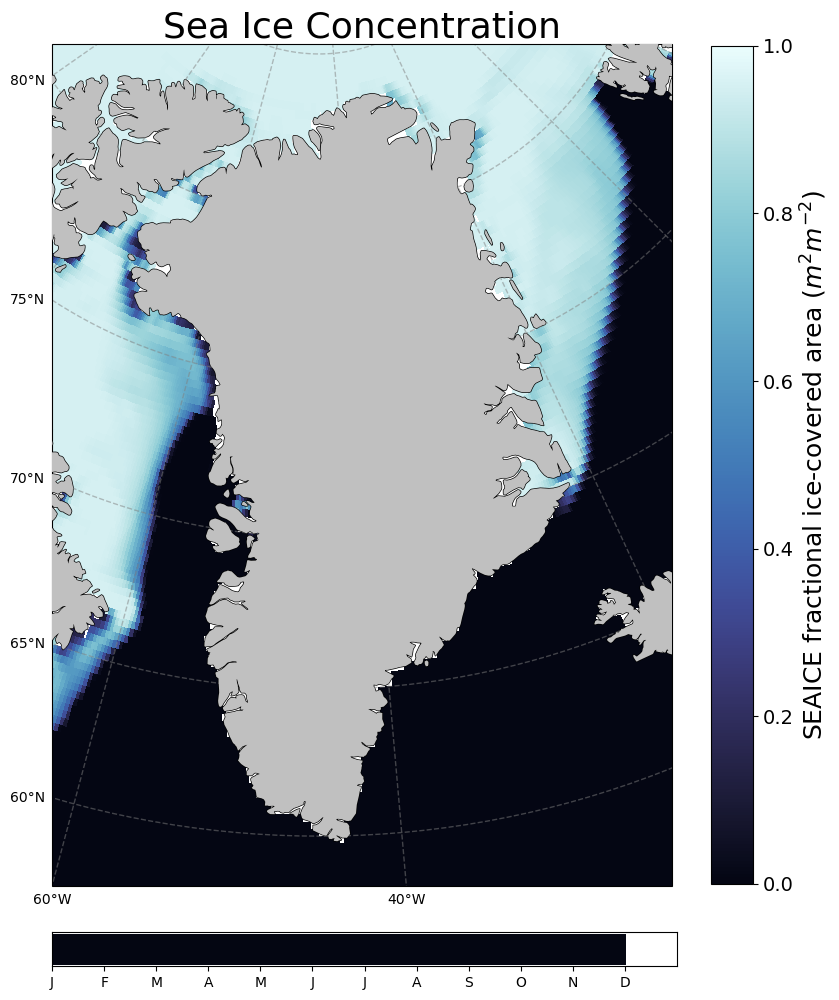

In [7]:
fig = plt.figure(figsize=(10, 17)) #, dpi=100)
ax = plt.axes(projection=gl_projection)


plt.pcolormesh(lon, lat, var, cmap=cm.ice, vmin=0, vmax=1,
               transform=ccrs.PlateCarree())

# add coastlines
ax.set_extent([-60, -25, 57, 85], crs=ccrs.PlateCarree())
plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver') #, alpha = 0.75)
plt.gca().coastlines()

# add lat/lon labels 
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 10}
gl.ylabel_style = {'size': 10}

# colorbar
cbar = plt.colorbar(orientation='vertical', ax=ax, shrink=0.64)
cbar.ax.tick_params(labelsize=14)
cbar.set_label('SEAICE fractional ice-covered area ($m^2 m^{-2}$)', fontsize=18)

plt.title('Sea Ice Concentration', fontsize=26, pad=.05)

year, month, day = 2002, 12, 1
# Calculate the progress as a fraction of the year
date = datetime.datetime(year, month, day)
start_of_year = datetime.datetime(year, 1, 1)
end_of_year = datetime.datetime(year, 12, 31)
total_days = (end_of_year - start_of_year).days + 1
current_day = (date - start_of_year).days + 1
progress = current_day / total_days

# progress bar
progress_ax = fig.add_axes([0.125, 0.2, 0.625, 0.02])  # [left, bottom, width, height]
progress_ax.barh(0, progress, color='#040612')
progress_ax.set_xlim(0, 1)
progress_ax.set_yticks([])
progress_ax.set_xticks([i/12 for i in range(12)])
progress_ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'])
# progress_ax.set_title(f'Progress: {date.strftime("%Y-%m-%d")}', fontsize=10)


# plt.savefig('seaice.png', bbox_inches='tight', dpi=100)
# plt.close()
plt.show()

Finally, make a plot with your subsetted data. For the plot specification, you can use any colormap, data range, and format as you like.

For my example, I find that the temperature plot looks nice with a figure size of (8,4), a turbo colormap, and a data range of 20-31. However, you are encouraged to format your plot to your tastes.

## Part 3: Formulate a Plotting Function
When you are happy with your plot, make your code into a function that will take the year, month, and day as inputs, and output the figure into a given directory. 

In [8]:
def plot_panel(year,month,day):
    plt.ioff() # making sure the plots dont show in the output
    file = os.path.join(data_folder, f'ECCO/Version5/Alpha/latlon_daily/{data_var}', f'{data_var}_{year}{month:02d}{day:02d}.nc')
    ds = xr.open_dataset(file, decode_times=False)
    var = np.array(ds[data_var][0,min_row:max_row+1, min_col:max_col+1])

    fig = plt.figure(figsize=(10, 17))
    ax = plt.axes(projection=gl_projection)

    plt.pcolormesh(lon, lat, var, cmap=cm.ice, vmin=0, vmax=1,
                transform=ccrs.PlateCarree())


    # add coastlines
    ax.set_extent([-60, -25, 57, 85], crs=ccrs.PlateCarree())
    plt.gca().add_feature(cfeature.LAND, zorder=99, facecolor='silver') #, alpha = 0.75)
    plt.gca().coastlines()


    # add lat/lon labels 
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                    linewidth=1, color='gray', alpha=0.5, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 10}
    gl.ylabel_style = {'size': 10}


    # colorbar
    cbar = plt.colorbar(orientation='vertical', ax=ax, shrink=0.64)
    cbar.ax.tick_params(labelsize=14)
    cbar.set_label('SEAICE fractional ice-covered area ($m^2 m^{-2}$)', fontsize=18)


    plt.title('Sea Ice Concentration', fontsize=26, pad=.05)


    # calculate the progress as a fraction of the year
    date = datetime.datetime(year, month, day)
    start_of_year = datetime.datetime(year, 1, 1)
    end_of_year = datetime.datetime(year, 12, 31)
    total_days = (end_of_year - start_of_year).days + 1
    current_day = (date - start_of_year).days + 1
    progress = current_day / total_days

    # progress bar
    progress_ax = fig.add_axes([0.125, 0.2, 0.625, 0.02])  # [left, bottom, width, height]
    progress_ax.barh(0, progress, color='#040612')
    progress_ax.set_xlim(0, 1)
    progress_ax.set_yticks([])
    progress_ax.set_xticks([i/12 for i in range(12)])
    progress_ax.set_xticklabels(['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D'], fontsize=14)
    # progress_ax.set_title(f'Progress: {date.strftime("%Y-%m-%d")}', fontsize=10)

    
    plt.savefig(f'./frames/{year}{month:02d}{day:02d}.png', dpi=100) #, bbox_inches='tight', dpi=100)
    plt.close()

Once the function is complete, use it to loop through all of the data to make a plot for each day of the year. The following lines of code will form the panels of a data visualization movie when using daily data. If you are using monthly data, update accordingly:

In [9]:
# loop through the data and make a plot for each day
year = 2001
for month in range(1,13):
    if month in [1,3,5,7,8,10,12]:
        n_days = 31
    elif month in [4,6,9,11]:
        n_days = 30
    else:
        if year%4==0:
            n_days = 29
        else:
            n_days = 28
    for day in range(1,n_days+1):
        print(f'{year}{month:02d}{day:02d}', end='\r')
        plot_panel(year,month,day)


## Part 4: Compile Panels into a Movie
After creating all of the panels, stitch them together into a movie using moviepy:

In [11]:
# make a list of files for each movie panel
frames_directory = './frames'
frames = [os.path.join(frames_directory, frame) for frame in os.listdir(frames_directory)]
frames = [frame for frame in frames if frame.split('/')[-1].startswith('2001')]

# sort the panels
frames.sort()

In [11]:
# set the frames per second
fps = 12

# use the ImageSequenceClip module to set up the clip
clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(frames, fps=fps)

# write the video to a file
# clip.write_gif('2001_seaice.gif', fps=fps)
clip.write_videofile('2001_seaice.mp4')

Moviepy - Building video 2001_seaice.mp4.
Moviepy - Writing video 2001_seaice.mp4



Moviepy - Done !
Moviepy - video ready 2001_seaice.mp4


## Part 5: Interpret Features in the Movie
A movie gives a good visualization of the physical processes occurring in a model. Describe one feature you see in the movie and relate it to an oceanographic feature. It could be a feature discussed in class or another feature you noticed and researched on your own.

Answer: 
My movie visualizes the fractional sea ice coverage around Greenland in 2001.

The air temperature at the North Pole is so cold that the sea surface freezes, creating sea ice, especially in the winter. This seasonality of sea ice forming in the winter and melting in the summer, notably around July, can be seen in the video. 

Additionally, you can see how the ocean currents effect the overall distribution of sea ice in the waters surrounding Greenland. 

In general, we can see that West Greenland's coastal waters experience less sea ice than the waters near Canada. This is partly due to the counter-clockwise ocean current. This current brings cold, less dense (less salty), polar water from the north counter-clockwise, where as the West Greenland coastal waters are getting warmer waters brought up from the North Atlantic Ocean current. Similarily, we can see this general feature to east of Greenland, where the counter-clockwise current is pulling that cold, polar water down along the East Greenland coast, allowing the formation of sea ice. 


